In [1]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from nltk.tokenize import word_tokenize
import numpy as np
import nltk

In [2]:
train_df = pd.read_csv("reviews_shuffled.txt", sep='\t', header=None)

In [28]:
label=[x[-1:] for x in train_df[0]]
data = [x[:-3] for x in train_df[0]]

In [4]:
print(label[0:10])
print(data[0:10])

['| 1', '| 1', '| 1', '| 0', '| 1', '| 0', '| 1', '| 0', '| 1', '| 0']
['a small movie with a big impact ', 'deliberately and skillfully uses ambiguity to suggest possibilities which imbue the theme with added depth and resonance ', 'poetry in motion captured on film while it can be a bit repetitive overall it s an entertaining and informative documentary ', 'basically a static series of semi improvised and semi coherent raps between the stars ', 'will assuredly rank as one of the cleverest most deceptively amusing comedies of the year ', 'did no one on the set have a sense of humor or did they not have the nerve to speak up ', 'young hanks and fisk who vaguely resemble their celebrity parents bring fresh good looks and an ease in front of the camera to the work ', 'too slick and manufactured to claim street credibility ', 'passable entertainment but it s the kind of motion picture that won t make much of a splash when it s released and will not be remembered long afterwards ', 'the me

In [5]:
from string import punctuation
# all_text = '\n'.join([c for c in data if c not in punctuation])
reviews_split = [c for c in data if c not in punctuation]
print(len(reviews_split))


10662


In [6]:
from collections import Counter

all_text2 = ' '.join(reviews_split)
# Count all the words using Counter Method
words = all_text2.split()
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)

In [7]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

In [8]:
print(len(reviews_split))
print(type(reviews_split[0]))

10662
<class 'str'>


In [9]:
reviews_int = []
for review in reviews_split:
    r = [vocab_to_int[w] for w in review.split()]
    reviews_int.append(r)
print(reviews_split[0])
print(reviews_int[0])

a small movie with a big impact 
[2, 403, 17, 14, 2, 124, 822]


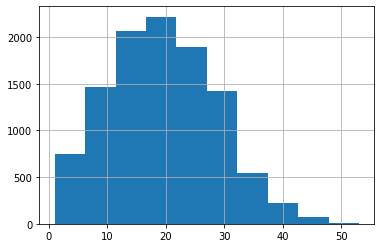

count    10662.000000
mean        19.360439
std          8.934985
min          1.000000
25%         13.000000
50%         19.000000
75%         25.000000
max         53.000000
dtype: float64

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
reviews_len = [len(x) for x in reviews_int]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

In [34]:
#Removing Outliers — Getting rid of extremely long or short reviews
reviews_int = [ reviews_int[i] for i, l in enumerate(reviews_len) if l>0 ]
encoded_labels = np.array([ label[i] for i, l in enumerate(reviews_len) if l> 0 ], dtype='i')

In [12]:
print(len(encoded_labels))
print(len(reviews_int))

10662
10662


In [35]:
#Padding / Truncating the remaining data
seq_length= 30
''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
'''
features = np.zeros((len(reviews_int), seq_length), dtype = int)

for i, review in enumerate(reviews_int):
    review_len = len(review)

    if review_len <= seq_length:
        zeroes = list(np.zeros(seq_length-review_len))
        new = zeroes+review
    elif review_len > seq_length:
        new = review[0:seq_length]

    features[i,:] = np.array(new)

print(features[:10,:])

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     2
    403    17    14     2   124   822]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0  3930     3  3931   576  2960     5  3387  4635    84 10080     1
   1246    14  3932   659     3  1713]
 [    0     0     0     0     0     0     0     0     0   974     9  1190
   3388    23    13    92     7    46    22     2   272  1302   584     7
      6    19   188     3  3933   178]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0  2192     2  2193   312     4  2403  2961     3
   2403  2194 10081   152     1   767]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0    59  7194  3389    11    26     4     1 10082    53
   2962   363   660     4     1   153]
 [    0     0     0     0     0     0     0     0     0   545    

In [36]:
#Training, Validation, Test Dataset Split
split_frac = 0.8
len_feat = len(features)

train_x = features[0:int(split_frac*len_feat)]
train_y = encoded_labels[0:int(split_frac*len_feat)]

remaining_x = features[int(split_frac*len_feat):]
remaining_y = encoded_labels[int(split_frac*len_feat):]

valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = remaining_y[0:int(len(remaining_y)*0.5)]

test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = remaining_y[int(len(remaining_y)*0.5):]

In [49]:
#Dataloaders and Batching

import torch
from torch.utils.data import DataLoader, TensorDataset
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
# dataloaders
batch_size = 16
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [50]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([16, 30])
Sample input: 
 tensor([[    0,     0,     0,     0,     0,  6144,  3899,  3276,     6,  4505,
           168,  8738,    93,   114,  2475,   246, 13602,     3,   560,  1966,
          3660,    14,     1,  2954,  2240,    18,  1010,   349,    34,  2568],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     2,   691,   849, 16256,    12,   890,   301,   257],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,  1696,   130],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,    90,  5426,    59,    22,  9258,    34,     2,   528,  9259,
             4,   197,   489,    12,  1394,    61,   139,   890,  4312,

In [51]:
import torch.nn as nn

class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [52]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2
net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)


SentimentLSTM(
  (embedding): Embedding(18342, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [53]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


# training params

epochs = 4 # 3-4 is approx where I noticed the validation loss stop decreasing

counter = 0
print_every = 100
clip=5 # gradient clipping

# move model to GPU, if available
train_on_gpu = torch.cuda.is_available()


net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        inputs = inputs.type(torch.LongTensor)
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                inputs = inputs.type(torch.LongTensor)
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

RuntimeError: Expected hidden[0] size (2, 10, 256), got (2, 16, 256)

In [ ]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # get predicted outputs
    inputs = inputs.type(torch.LongTensor)
    output, h = net(inputs, h)
    
    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer
    
    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

In [54]:
vocab_size

18342